# Trigger efficiency in signal files 

In this notebook we explore how efficient trigger selections are on our signal simulation file.

We first download one file from a simulated signal dataset (Higgs to WW in the lepton-neutrino-quark-quark final state):

```
mkdir data/
scp -r cmslpc-sl7.fnal.gov:/eos/uscms/store/user/lpcdihiggsboost/cmantill/PFNano/2017_UL_ak15/GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8/RunIISummer19UL17Jun23-106X_mc2017_realistic_v6-v2/210623_225150/0000/nano_mc2017_1-130.root data/nano_mc2017_1-130.root
```

Then, we import some libraries:

In [14]:
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")

Define the matching function:

In [2]:
def getParticles(genparticles,lowid=22,highid=25,flags=['fromHardProcess', 'isLastCopy']):
    """
    returns the particle objects that satisfy a low id, 
    high id condition and have certain flags
    """
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

def match_HWWlepqq(genparticles,candidatefj):
    """
    return the number of matched objects (hWW*),daughters, 
    and gen flavor (enuqq, munuqq, taunuqq) 
    """
    higgs = getParticles(genparticles,25)
    is_hWW = ak.all(abs(higgs.children.pdgId)==24,axis=2)

    higgs = higgs[is_hWW]
    higgs_wstar = higgs.children[ak.argmin(higgs.children.mass,axis=2,keepdims=True)]
    higgs_w = higgs.children[ak.argmax(higgs.children.mass,axis=2,keepdims=True)]
    
    prompt_electron = getParticles(genparticles,11,11,['isPrompt','isLastCopy'])
    prompt_muon = getParticles(genparticles,13,13,['isPrompt', 'isLastCopy'])
    prompt_tau = getParticles(genparticles,15,15,['isPrompt', 'isLastCopy'])
    prompt_q = getParticles(genparticles,0,5,['fromHardProcess', 'isLastCopy'])
    prompt_q = prompt_q[abs(prompt_q.distinctParent.pdgId) == 24]
    
    dr_fj_quarks = candidatefj.delta_r(prompt_q)
    dr_fj_electrons = candidatefj.delta_r(prompt_electron)
    dr_fj_muons = candidatefj.delta_r(prompt_muon)
    dr_fj_taus = candidatefj.delta_r(prompt_tau)
    dr_daughters = ak.concatenate([dr_fj_quarks,dr_fj_electrons,dr_fj_muons,dr_fj_taus],axis=1)
    hWWlepqq_nprongs = ak.sum(dr_daughters<0.8,axis=1)
    
    n_electrons = ak.sum(prompt_electron.pt>0,axis=1)
    n_muons = ak.sum(prompt_muon.pt>0,axis=1)
    n_taus = ak.sum(prompt_tau.pt>0,axis=1)
    n_quarks = ak.sum(prompt_q.pt>0,axis=1)

    # 4(elenuqq),6(munuqq),8(taunuqq)
    hWWlepqq_flavor = (n_quarks==2)*1 + (n_electrons==1)*3 + (n_muons==1)*5 + (n_taus==1)*7
    
    matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)
    matchedW = candidatefj.nearest(higgs_w, axis=1, threshold=0.8)
    matchedWstar = candidatefj.nearest(higgs_wstar, axis=1, threshold=0.8) 

    # 1 (H only), 4(W), 6(W star), 9(H, W and Wstar)
    hWWlepqq_matched = (
        (ak.sum(matchedH.pt > 0, axis=1)==1) * 1 
        + (ak.sum(ak.flatten(matchedW.pt > 0, axis=2), axis=1)==1) * 3 
        + (ak.sum(ak.flatten(matchedWstar.pt > 0, axis=2), axis=1)==1) * 5
    )
    
    # leptons matched
    dr_leptons = ak.concatenate([dr_fj_electrons,dr_fj_muons], axis=1)
    matched_leptons = dr_leptons < 0.8
    
    leptons = ak.concatenate([prompt_electron, prompt_muon], axis=1)
    leptons = leptons[matched_leptons]
    
    # leptons coming from W or W*
    leptons_mass = ak.firsts(leptons.distinctParent.mass)
    higgs_w_mass = ak.firsts(ak.flatten(higgs_w.mass))[ak.firsts(leptons.pt > 0)]
    higgs_wstar_mass = ak.firsts(ak.flatten(higgs_wstar.mass))[ak.firsts(leptons.pt > 0)]

    iswlepton = (leptons_mass == higgs_w_mass)
    iswstarlepton = (leptons_mass == higgs_wstar_mass)
    
    # let's return only:
    # - matchedH (the higgs boson that is matched to the jet)
    # - (iswlepton,iswstarlepton)
    return matchedH,iswlepton,iswstarlepton

Now, let's define a processor:

In [6]:
import numpy as np
import hist as hist2
from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

# function to normalize arrays after a cut or selection
def normalize(val, cut=None):
    if cut is None:
        ar = ak.to_numpy(ak.fill_none(val, np.nan))
        return ar
    else:
        ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
        return ar

# (1) how efficient are triggers on your signal. You don't want your triggers to not select most of your signal events
# Which triggers you should include in the selection?

# (2) how efficient are triggers on your data (un-labeled)?
  # - measure this in a region that is somewhat similar to the signature that you are looking for
# Two classic approaches:
# - measure trigger efficiency in data
#    - Apply "trigger efficiency" as a weight to your MC 
# - measure trigger efficiency in data, measure trigger efficiency in MC (all background?): 
#    - Scale factor: (eff_data)/(eff_mc)
#    - Apply trigger to data
#    - Apply "Simulation of trigger" to MC
#    - Apply SF to MC
    
class TriggerEfficienciesProcessor(processor.ProcessorABC):
    """ Accumulates histograms from all input events: 1) before triggers, and 2) after triggers """
    def __init__(self, triggers=["nominal","vvl","lepjet","jet"]):
        super(TriggerEfficienciesProcessor, self).__init__()
        
        # full list of trigger that CAN be tested for each channel
        # first let's test for 2017 ONLY (we need to test 2016/2018)
        # e.g. list for reference: https://github.com/drankincms/boostedhiggs/blob/dev/boostedhiggs/htautauprocessor_trig_gen.py
        trigger_dict = {
            "e_nominal": [
                          "Ele35_WPTight_Gsf", # electron trigger with isolation
                          "Ele115_CaloIdVT_GsfTrkIdT", # electron trigger without isolation
                        ],
            "e_jet": ["Ele50_CaloIdVT_GsfTrkIdT_PFJet165"],
            "e_vvl": ["Ele15_IsoVVVL_PFHT600",
                      "Ele15_IsoVVVL_PFHT450_PFMET50",
                    ],
            "jet": ["PFHT1050",
                    "AK8PFJet400_TrimMass30",
                    "AK8PFJet420_TrimMass30",
                    "AK8PFHT800_TrimMass50",
                    "PFJet500",
                    "AK8PFJet500",
                   ],
            "mu_nominal": [
                           "IsoMu27", # muon trigger with isolation
                           "Mu50", # muon trigger without isolation
                          ],
            "mu_vvl": ["Mu15_IsoVVVL_PFHT450_PFMET50",
                       "Mu15_IsoVVVL_PFHT600",
                      ],
            
        }
         
        # list of triggers that WILL be tested
        self._triggers = {"e": [],
                          "mu": [],
                          # "had": [],
                         }
        if "nominal" in triggers:
            self._triggers["e"] += trigger_dict["e_nominal"]
            self._triggers["mu"] += trigger_dict["mu_nominal"]
            # self._triggers["had"] = "jet"
        if "vvl" in triggers:
            self._triggers["e"] += trigger_dict["e_vvl"]
            self._triggers["mu"] += trigger_dict["mu_vvl"]
        if "lepjet" in triggers:
            self._triggers["e"] += trigger_dict["e_jet"]
        if "jet" in triggers:
            self._triggers["e"] += trigger_dict["jet"]
            self._triggers["mu"] += trigger_dict["jet"]
        
        jetpt_axis = hist2.axis.Regular(30, 200, 700, name='jetpt', label=r'Jet $p_T$ [GeV]')
        # jeteta_axis = hist2.axis.Regular(30, -2.4, 2.4, name='jeteta', label=r'Jet eta')
        jetmsoftdrop_axis = hist2.axis.Regular(20, 20, 200, name='jetmsoftdrop', label=r'Jet soft drop mass')   #candidatejet.msoftdrop
        jetlepmass_axis = hist2.axis.Regular(20, 20, 200, name='jetlepmass', label=r'Mass of the (jet-lepton) system')   #(candidatefj - candidatelep).mass
        leppt_axis = hist2.axis.Regular(30, 10, 200, name='leppt', label=r'Lepton $p_T$ [GeV]')
        hpt_axis = hist2.axis.Regular(50, 10, 800, name='higgspt', label=r'matched H $p_T$ [GeV]')

        region_cat = hist2.axis.StrCategory(["numerator","denominator"], name="region")
        channel_cat = hist2.axis.StrCategory([], name='channel', growth=True)
        
        self.make_output = lambda: {
            "jet": hist2.Hist(
                channel_cat,
                region_cat,
                jetpt_axis,
                # jeteta_axis,
                jetmsoftdrop_axis,
                jetlepmass_axis,
            ),
            "lepton": hist2.Hist(
                channel_cat,
                region_cat,
                leppt_axis,
            ),
            "higgs": hist2.Hist(
                channel_cat,
                region_cat,
                hpt_axis,
            )
        }
        
        self._channels = ["e","mu"]
    
    def process(self, events):
        """ Returns pre- (den) and post- (num) trigger histograms from input NanoAOD events """
        dataset = events.metadata['dataset']
        selection = PackedSelection()
        isRealData = not hasattr(events, "genWeight")
        nevents = len(events)
        
        # make output
        output = self.make_output()
        
        # apply trigger (to all datasets)
        triggers = {}
        for channel in self._channels:
            trigger = np.zeros(len(events), dtype='bool')
            for t in self._triggers[channel]:
                if t in events.HLT.fields:
                    trigger = trigger | events.HLT[t]
            triggers['trigger'+channel] = trigger
            del trigger
        
        # add basic selection
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        lowptmuon = (
            (events.Muon.pt > 10)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.looseId
        )
        nlowptmuons = ak.sum(lowptmuon, axis=1)

        goodelectron = (
            (events.Electron.pt > 25)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.mvaFall17V2noIso_WP80)
        )
        nelectrons = ak.sum(goodelectron, axis=1)
        lowptelectron = (
            (events.Electron.pt > 10)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.cutBased >= events.Electron.LOOSE)
        )
        nlowptelectrons = ak.sum(lowptelectron, axis=1)
        
        # get candidate lepton
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        
        # define isolation
        lep_miniIso = candidatelep.miniPFRelIso_all
        lep_relIso = candidatelep.pfRelIso03_all
        mu_iso = ( ((candidatelep.pt < 55.) & (lep_relIso < 0.25)) | 
                     ((candidatelep.pt >= 55.) & (lep_miniIso < 0.1)) )
        el_iso = ( ((candidatelep.pt < 120.) & (lep_relIso < 0.25)) |
                   ((candidatelep.pt >= 120.) & (lep_miniIso < 0.1)) )
           
        # taus
        goodtau = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEle >= 8)
            & (events.Tau.idAntiMu >= 1)
        )
        ntaus = ak.sum(goodtau, axis=1)
        
        # get candidate jets
        fatjets = events.FatJet
        candidatefj = fatjets[
            (fatjets.pt > 200) &
            (abs(fatjets.eta) < 2.4)
        ]
            
        met = events.MET
        dphi_met_fj = abs(candidatefj.delta_phi(met))
        dr_lep_fj = candidatefj.delta_r(candidatelep)
            
        # select jet closest to met
        candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
       
        # do matching
        if "HToWW" in dataset:
            matchedH,iswlepton,iswstarlepton = match_HWWlepqq(events.GenPart,candidatefj)
            matchedH_pt = ak.firsts(matchedH.pt)
        else:
            matchedH_pt = ak.zeros_like(candidatefj.pt)
            iswlepton = ak.ones_like(candidatefj.pt, dtype=bool)
            iswstarlepton = ak.ones_like(candidatefj.pt, dtype=bool)
        
        # add selections
        for channel in ["e","mu"]:
            selection.add('trigger'+channel, triggers['trigger'+channel] )
            
        # selection.add("iswlepton", iswlepton)
        # selection.add("iswstarlepton", iswstarlepton)
        selection.add('fjkin', candidatefj.pt > 200)
        selection.add('onemuon', (nmuons == 1) & (nlowptmuons <= 1) & (nelectrons == 0) & (nlowptelectrons == 0) & (ntaus == 0))
        selection.add('oneelectron', (nelectrons == 1) & (nlowptelectrons <= 1) & (nmuons == 0) & (nlowptmuons == 0) & (ntaus == 0))
        # selection.add('muonkin', (candidatelep.pt > 30.) & abs(candidatelep.eta < 2.4))
        # selection.add('electronkin', (candidatelep.pt > 40.) & abs(candidatelep.eta < 2.4))
        # selection.add("muoniso", mu_iso)
        # selection.add("electroniso", el_iso)

        # define numerator and denominator
        regions = {"denominator": {"e": ["fjkin","oneelectron"],
                                   "mu": ["fjkin","onemuon"],
                                  },
                   "numerator": dict.fromkeys(["e","mu"]),
                  }
                        
#         ### TODO: i uncommented the next two lines and added the "electroniso" region to regions below
#         selection.add("muoniso", mu_iso)
#         selection.add("electroniso", el_iso)

#         # define numerator and denominator
#         regions = {"denominator": {"e": ["fjkin","oneelectron","electroniso"],
#                                    "mu": ["fjkin","onemuon","electroniso"],
#                                   },
#                    "numerator": dict.fromkeys(["e","mu"]),
#                   }
                                          
        # numerator is all the selection from denominator + trigger
        for channel,region in regions["denominator"].items():
            regions["numerator"][channel] = region + ["trigger"+channel]
                    
        def fill(region,channel):
            selections = regions[region][channel]
            cut = selection.all(*selections)
            
            output['jet'].fill(
                channel=channel,
                region=region,
                jetpt=normalize(candidatefj.pt, cut),
                # let's try adding eta just for curiosity
                # jeteta=normalize(candidatefj.eta, cut),
                jetmsoftdrop=normalize(candidatefj.msoftdrop, cut),
                jetlepmass=normalize((candidatefj - candidatelep).mass, cut),

            )
            output['lepton'].fill(
                channel=channel,
                region=region,
                leppt=normalize(candidatelep.pt, cut),
            )
            output['higgs'].fill(
                channel=channel,
                region=region,
                higgspt=normalize(matchedH_pt, cut),
            )
            
        for region,chan in regions.items():
            for channel in chan.keys():
                fill(region,channel)

        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

You can save the output using pickle

In [4]:
import pickle

filehandler = open(f"test_hww.pkl", "wb")
pickle.dump(out, filehandler)
filehandler.close()

NameError: name 'out' is not defined

Some hist references: https://github.com/scikit-hep/hist
Taking a look at the output:

In [ ]:
out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']

{'jet': Hist(
   StrCategory(['e', 'mu'], growth=True, name='channel', label='channel'),
   StrCategory(['numerator', 'denominator'], name='region', label='region'),
   Regular(30, 200, 700, name='jetpt', label='Jet $p_T$ [GeV]'),
   Regular(30, -2.4, 2.4, name='jeteta', label='Jet eta'),
   storage=Double()) # Sum: 104831.0 (105045.0 with flow),
 'lepton': Hist(
   StrCategory(['e', 'mu'], growth=True, name='channel', label='channel'),
   StrCategory(['numerator', 'denominator'], name='region', label='region'),
   Regular(30, 10, 200, name='leppt', label='Lepton $p_T$ [GeV]'),
   storage=Double()) # Sum: 99864.0 (105045.0 with flow),
 'higgs': Hist(
   StrCategory(['e', 'mu'], growth=True, name='channel', label='channel'),
   StrCategory(['numerator', 'denominator'], name='region', label='region'),
   Regular(50, 10, 800, name='higgspt', label='matched H $p_T$ [GeV]'),
   storage=Double()) # Sum: 52888.0 (105045.0 with flow)}

In [ ]:
out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet']

Hist(
  StrCategory(['e', 'mu'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  Regular(30, 200, 700, name='jetpt', label='Jet $p_T$ [GeV]'),
  Regular(30, -2.4, 2.4, name='jeteta', label='Jet eta'),
  storage=Double()) # Sum: 104831.0 (105045.0 with flow)

In [30]:
jeteta_den_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "e", "jeteta": sum}]
jeteta_den_e

Hist(Regular(30, 200, 700, name='jetpt', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 24144.0 (24159.0 with flow)

In [9]:
import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval

NameError: name 'jetpt_num_e' is not defined

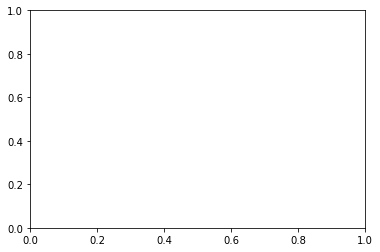

In [10]:
fig, ax = plt.subplots(1, 1)

hep.histplot(jetpt_num_e/jetpt_den_e, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(jetpt_num_e.view(), jetpt_den_e.view()) - jetpt_num_e.view()/jetpt_den_e.view()),
             ax = ax,
             histtype='errorbar', color='k', capsize=4, elinewidth=1,           
)
#ax.set_ylim(0, 1)
ax.set_xlim(200, 1000)
ax.set_title(f'Candidate jet $p_T$ GeV')

/Users/cmantill/miniconda3/envs/hww/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 1.0, 'Candidate jet $p_T$ GeV')

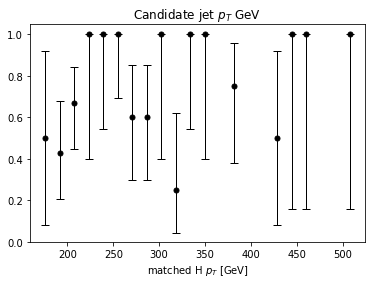

In [18]:
fig, ax = plt.subplots(1, 1)

num = out['HToWW']['higgs'][{"region": "numerator","channel": "e"}]
den = out['HToWW']['higgs'][{"region": "denominator","channel": "e"}]

hep.histplot(num/den, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view()),
             ax = ax,
             histtype='errorbar', color='k', capsize=4, elinewidth=1,           
)
#ax.set_ylim(0, 1)
ax.set_title(f'Candidate jet $p_T$ GeV')

Or you can run the processor using dask. Make sure to download the json file from below that contains the full list of files.

## DASK

In [7]:
# define the client
from dask.distributed import Client

client = Client("tls://localhost:8786")

In [23]:
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import json

# define the full fileset
# download this file in a new terminal in coffea casa: 
# wget https://raw.githubusercontent.com/cmantill/boostedhiggs/main/fileset/fileset_2017_UL_NANO.json
# the dataset that we will run on is called: GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8
dataset_name = "GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8"
with open("fileset_2017_UL_NANO.json", 'r') as f:
    files = json.load(f)[dataset_name]
fileset = {}
# need to define the fileset but call them with xcache
fileset[dataset_name] = ["root://xcache/"+ f for f in files]

uproot.open.defaults['xrootd_handler'] = uproot.source.xrootd.MultithreadedXRootDSource

# define processor
p = TriggerEfficienciesProcessor(triggers=["vvl"])

# define executor (dask)
# https://coffeateam.github.io/coffea/api/coffea.processor.DaskExecutor.html
executor = processor.DaskExecutor(compression=1, status=True, client=client, treereduction=2)

# define the runner (Same as before)
run = processor.Runner(executor=executor,savemetrics=True,chunksize=10000,schema=NanoAODSchema)

# run
out,metrics = run(fileset,'Events',processor_instance=p)

In [45]:
fname = fileset['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']
c = 0
for i in range(len(fname)):
    events = NanoEventsFactory.from_root(fname[i], schemaclass=NanoAODSchema).events()
    c = c+len(events)
print('Number of events:', c)

In [52]:
out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{'channel':'e','region':'denominator','jeteta':sum}]

Hist(Regular(30, 200, 700, name='jetpt', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 24144.0 (24159.0 with flow)

In [53]:
out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{'channel':'e','region':'denominator','jeteta':sum}]

Hist(Regular(30, 200, 700, name='jetpt', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 24144.0 (24159.0 with flow)

In [18]:

out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet']

Hist(
  StrCategory(['e', 'mu'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  Regular(30, 200, 700, name='jetpt', label='Jet $p_T$ [GeV]'),
  Regular(20, 20, 200, name='jetmsoftdrop', label='Jet soft drop mass'),
  Regular(20, 20, 200, name='jetlepmass', label='Mass of the (jet-lepton) system'),
  storage=Double()) # Sum: 44608.0 (105045.0 with flow)

### Preliminary plots

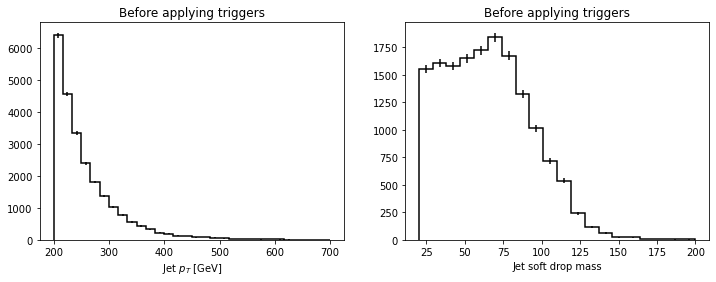

In [20]:
### before applying triggers (distribution plots)
jet_pt_deno = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{'channel':'e','region':'denominator','jetlepmass': sum,'jetmsoftdrop':sum}]
jetmsoftdrop_deno = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{'channel':'e','region':'denominator','jetlepmass':sum,'jetpt':sum}]

f, axs = plt.subplots(1,2, figsize=(12, 4))
hep.histplot(jet_pt_deno, yerr=True, ax=axs[0], color='k', label='semi-leptonic jets')
hep.histplot(jetmsoftdrop_deno, yerr=True, ax=axs[1], color='k', label='semi-leptonic jets')
axs[0].set_title('Before applying triggers')
axs[1].set_title('Before applying triggers');

# ### after applying triggers
# jet_pt_num = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8'][{'channel':'e','region':'numerator','jetlepmass': sum,'jetmsoftdrop':sum}]
# jetmsoftdrop_num = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{'channel':'e','region':'numerator','jetlepmass':sum,'jetpt':sum}]

# f, axs = plt.subplots(1,2, figsize=(12, 4))
# hep.histplot(jet_pt_num, yerr=True, ax=axs[0], color='k', label='semi-leptonic jets')
# hep.histplot(jetmsoftdrop_num, yerr=True, ax=axs[1], color='k', label='semi-leptonic jets')
# axs[0].set_title('After applying triggers')
# axs[1].set_title('After applying triggers');

### Trigger efficiency plots

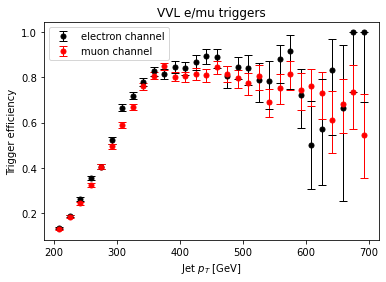

In [34]:
fig, ax = plt.subplots(1, 1)

num_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "e", 'jetlepmass':sum,'jetmsoftdrop':sum}]
den_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "e", 'jetlepmass':sum,'jetmsoftdrop':sum}]
num_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "mu", 'jetlepmass':sum,'jetmsoftdrop':sum}]
den_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "mu", 'jetlepmass':sum,'jetmsoftdrop':sum}]

hep.histplot(num_e/den_e, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
             ax = ax,
             histtype='errorbar', color='k', capsize=4, elinewidth=1, label='electron channel'          
)

hep.histplot(num_mu/den_mu, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),
             ax = ax,
             histtype='errorbar', color='r', capsize=4, elinewidth=1, label='muon channel'          
)

#ax.set_ylim(0, 1)
# ax.set_title(f'Candidate jet $p_T$ GeV')
ax.set_ylabel(f'Trigger efficiency');
ax.set_title(f'VVL e/mu triggers')
plt.legend()

/tmp/ipykernel_119/2367790301.py:10: RuntimeWarning: invalid value encountered in true_divide
  yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
/tmp/ipykernel_119/2367790301.py:17: RuntimeWarning: invalid value encountered in true_divide
  yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),


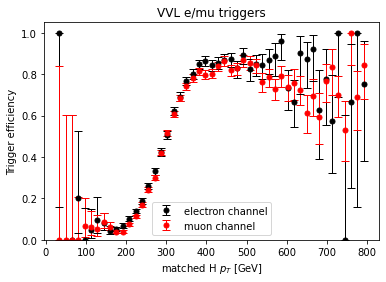

In [27]:
fig, ax = plt.subplots(1, 1)

num_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['higgs'][{"region": "numerator","channel": "e"}]
den_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['higgs'][{"region": "denominator","channel": "e"}]
num_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['higgs'][{"region": "numerator","channel": "mu"}]
den_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['higgs'][{"region": "denominator","channel": "mu"}]

hep.histplot(num_e/den_e, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
             ax = ax,
             histtype='errorbar', color='k', capsize=4, elinewidth=1, label='electron channel'         
)

hep.histplot(num_mu/den_mu, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),
             ax = ax,
             histtype='errorbar', color='r', capsize=4, elinewidth=1, label='muon channel'          
)
#ax.set_ylim(0, 1)
# ax.set_title(f'Candidate jet $p_T$ GeV')
ax.set_ylabel(f'Trigger efficiency')
ax.set_title(f'VVL e/mu triggers')
plt.legend()
plt.savefig('lol.pdf');

In [21]:
out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet']

Hist(
  StrCategory(['e', 'mu'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  Regular(30, 200, 700, name='jetpt', label='Jet $p_T$ [GeV]'),
  Regular(20, 20, 200, name='jetmsoftdrop', label='Jet soft drop mass'),
  Regular(20, 20, 200, name='jetlepmass', label='Mass of the (jet-lepton) system'),
  storage=Double()) # Sum: 44608.0 (105045.0 with flow)

/tmp/ipykernel_119/267002695.py:10: RuntimeWarning: invalid value encountered in true_divide
  yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
/tmp/ipykernel_119/267002695.py:17: RuntimeWarning: invalid value encountered in true_divide
  yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),


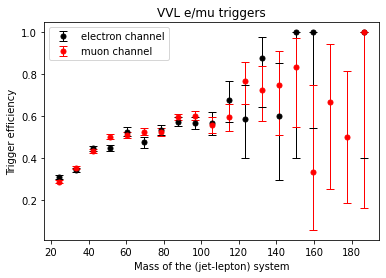

In [26]:
fig, ax = plt.subplots(1, 1)

num_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "e", 'jetmsoftdrop':sum, 'jetpt':sum}]
den_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "e", 'jetmsoftdrop':sum, 'jetpt':sum}]
num_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "mu", 'jetmsoftdrop':sum, 'jetpt':sum}]
den_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "mu", 'jetmsoftdrop':sum, 'jetpt':sum}]

hep.histplot(num_e/den_e, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
             ax = ax,
             histtype='errorbar', color='k', capsize=4, elinewidth=1, label='electron channel'         
)

hep.histplot(num_mu/den_mu, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),
             ax = ax,
             histtype='errorbar', color='r', capsize=4, elinewidth=1, label='muon channel'          
)
#ax.set_ylim(0, 1)
# ax.set_title(f'Candidate jet $p_T$ GeV')
ax.set_ylabel(f'Trigger efficiency')
ax.set_title(f'VVL e/mu triggers')
plt.legend()
plt.savefig('lol.pdf');

In [ ]:
fig, ax = plt.subplots(1, 1)

num_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "e", 'jetlepmass':sum, 'jetpt':sum}]
den_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "e", 'jetlepmass':sum, 'jetpt':sum}]
num_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "mu", 'jetlepmass':sum, 'jetpt':sum}]
den_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "mu", 'jetlepmass':sum, 'jetpt':sum}]

hep.histplot(num_e/den_e, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
             ax = ax,
             histtype='errorbar', color='k', capsize=4, elinewidth=1, label='electron channel'         
)

hep.histplot(num_mu/den_mu, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),
             ax = ax,
             histtype='errorbar', color='r', capsize=4, elinewidth=1, label='muon channel'          
)
#ax.set_ylim(0, 1)
# ax.set_title(f'Candidate jet $p_T$ GeV')
ax.set_ylabel(f'Trigger efficiency')
ax.set_title(f'VVL e/mu triggers')
plt.legend()
plt.savefig('lol.pdf');